# **DATA IMPORT AND DATASET POPULATION**

### Data import

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
#General libraries import
import tensorflow as tf
import keras
import numpy as np
import os.path

In [12]:
#Downloading and unzipping the dataset from kaggle

! pip install -q kaggle
! mkdir ~/.kaggle
! cp drive/MyDrive/Progetto/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d phylake1337/fire-dataset
! unzip fire-dataset.zip 

 97% 377M/387M [00:05<00:00, 99.1MB/s]
100% 387M/387M [00:05<00:00, 72.7MB/s]
Archive:  fire-dataset.zip
  inflating: fire_dataset/fire_images/fire.1.png  
  inflating: fire_dataset/fire_images/fire.10.png  
  inflating: fire_dataset/fire_images/fire.100.png  
  inflating: fire_dataset/fire_images/fire.101.png  
  inflating: fire_dataset/fire_images/fire.102.png  
  inflating: fire_dataset/fire_images/fire.103.png  
  inflating: fire_dataset/fire_images/fire.104.png  
  inflating: fire_dataset/fire_images/fire.105.png  
  inflating: fire_dataset/fire_images/fire.106.png  
  inflating: fire_dataset/fire_images/fire.107.png  
  inflating: fire_dataset/fire_images/fire.108.png  
  inflating: fire_dataset/fire_images/fire.109.png  
  inflating: fire_dataset/fire_images/fire.11.png  
  inflating: fire_dataset/fire_images/fire.110.png  
  inflating: fire_dataset/fire_images/fire.111.png  
  inflating: fire_dataset/fire_images/fire.112.png  
  inflating: fire_dataset/fire_images/fire.113.png 

### Dataset population ###

In [13]:
dataset = "fire_dataset" 
import pandas as pd
#Definition of the function to create the dataframe containing filepaths and labels for the data
def make_dataframe(path):
  filelist = []
  
  #For loop to iterate into the directories and append the path to the filename
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          filelist.append(os.path.join(dirname, filename))
  Filepaths = []
  labels = []
  #each image_file is splitted in label and filepath
  for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)
  
  #Two pandas series are created from filepaths and labels in order to create the dataframe
  Fseries = pd.Series(Filepaths, name="Filepath")
  Lseries = pd.Series(labels, name="Label")
  df = pd.concat([Fseries, Lseries], axis=1)
  df = (df.sample(frac=1, random_state=42).reset_index()).drop(columns="index")
  return df

In [14]:
#Creation of the dataframe containing all the images
image_df = make_dataframe(dataset)

In [15]:
image_df

,Filepath,Label
0,fire_dataset/fire_images/fire.447.png,fire_images
1,fire_dataset/non_fire_images/non_fire.7.png,non_fire_images
2,fire_dataset/fire_images/fire.377.png,fire_images
3,fire_dataset/fire_images/fire.407.png,fire_images
4,fire_dataset/fire_images/fire.600.png,fire_images
...,...,...
994,fire_dataset/fire_images/fire.422.png,fire_images
995,fire_dataset/fire_images/fire.694.png,fire_images
996,fire_dataset/non_fire_images/non_fire.214.png,non_fire_images
997,fire_dataset/fire_images/fire.265.png,fire_images


In [16]:
#Subsampling the main dataframe into a balanced dataframe with 40 samples per class
img_samples = 40
samples = []
#For loop iterating for each label in the main dataframe
for category in image_df['Label'].unique():    
    #Query the column with the label equal to the category taken into account
    category_slice = image_df.query("Label == @category") 
    #Subsampling only 40 elements from the above category_slice and appending them into the samples dataframe
    samples.append(category_slice.sample(img_samples, replace=False,random_state=1))
#concatenating the samples to make the dataframe
test_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [17]:
#Visualizing the frequency count of instances in the test dataframe
test_df['Label'].value_counts(normalize=True)

non_fire_images    0.5
fire_images        0.5
Name: Label, dtype: float64

In [18]:
#Dropping the test_dataframe instances from the main dataframe
image_df=image_df.drop(test_df.index)

In [19]:
#Visualizing the frequency count of instances in the total training dataframe
image_df['Label'].value_counts(normalize=True)

fire_images        0.752992
non_fire_images    0.247008
Name: Label, dtype: float64

In [20]:
from sklearn.model_selection import train_test_split
#Splitting the image_df into training and validation dataframe, shuffling the data and maitaining the ratio between classes
train_df, val_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=42)

In [21]:
#Ratio between classes in training and validation dataframe are almost equal
train_df['Label'].value_counts(normalize=True)

fire_images        0.755832
non_fire_images    0.244168
Name: Label, dtype: float64

In [22]:
val_df['Label'].value_counts(normalize=True)

fire_images        0.746377
non_fire_images    0.253623
Name: Label, dtype: float64

In [23]:
from keras.preprocessing.image import ImageDataGenerator
img_size = (224,224)

#Instantiating an ImageDataGenerator class used for training and validation with the augmentation and the preprocessing function
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                           rotation_range=10,
                           horizontal_flip='True')
#Instantiating an ImageDataGenerator class used for test with only the preprocessing function
testgen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

#Calling the method flow_from_dataframe to have a DataFrameIterator containing batch images and labels for each set
train_images = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True, 
    seed=21
    )

val_images = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=21
)

test_images = testgen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 643 validated image filenames belonging to 2 classes.
Found 276 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


### Data visualization ###

In [24]:
#We extract a batch of images to visualize them
image, label = next(iter(train_images))

In [25]:
#Creating a sequential model to rescale images into [0,1] range in order to be visualized
from keras import layers
rescale = tf.keras.Sequential([
  layers.Rescaling(1,offset=+1),
  layers.Rescaling(1./2)
])

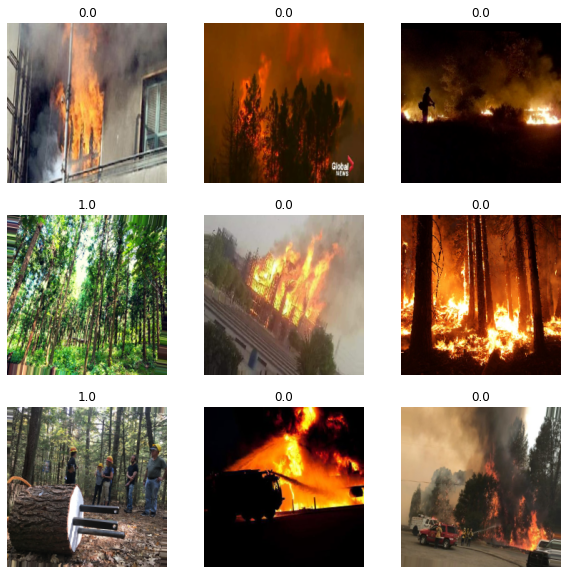

In [26]:
#Here are going to be displayed 9 images from the batch previously extracted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  im = rescale(image[i])
  ax = plt.subplot(3, 3, i + 1)
  ax.set_title(label[i])
  plt.imshow(im)
  plt.axis("off")

# **MODEL DEFINITION AND TRAINING**

### Model Definition

In [61]:
#Loading the pretrained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), #Input shape preferable for MobileNetV2
    include_top=False,  #Not including the densely connected classifier
    weights='imagenet'
)

In [62]:
#Freezing all the weights of the base convolutional model
base_model.trainable = False

In [63]:
#Defining a function to build the model from functional API
from keras import layers
def build_model():

  input = layers.Input(shape=(224,224,3))
  x = base_model(input, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  output = layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=input,outputs=output)              
  return model

In [64]:
#Building the model and visualizing its summary
model = build_model()
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


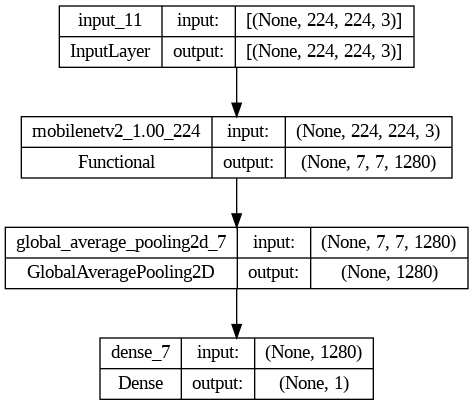

In [65]:
#Plotting the model 
tf.keras.utils.plot_model(model, show_shapes=True)

In [66]:
#Callbacks for the model training
from datetime import datetime  
name = datetime.now().strftime("fire_%d_%m_%Y_%H_%M_%S.keras")  
callbacks = [
    #ModelCheckpoint will save only the best model respect to "val_loss" value into the "name" model
    keras.callbacks.ModelCheckpoint(
        filepath=name,
        verbose=1,
        save_best_only=True,
        monitor="val_loss"),
    # EarlyStopping will stop the training after 5 epochs with no improvement on the "val_loss" value
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        patience=10,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]

In [67]:
from keras.optimizers import Adam
#Compiling the model using binary crossentropy as loss function, Adam as optimizer and using Accuracy, Precision and Recall as metrics
model.compile(
      optimizer = "Adam", 
      loss='binary_crossentropy', 
      metrics=['Precision','Recall','accuracy']
      )  

### Initial Training

In [68]:
#Training of the model on maximium 20 epochs
history = model.fit(train_images, 
                    epochs=20, 
                    validation_data=val_images,
                    callbacks=callbacks
                    )

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.3315 - precision: 0.7891 - recall: 0.5549 - accuracy: 0.8533
Epoch 1: val_loss improved from inf to 0.19044, saving model to fire_15_03_2023_10_04_22.keras
23/23 [==============================] - 39s 2s/step - loss: 0.3315 - precision: 0.7891 - recall: 0.5549 - accuracy: 0.8533 - val_loss: 0.1904 - val_precision: 0.9211 - val_recall: 0.7778 - val_accuracy: 0.9290
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.1418 - precision: 0.9643 - recall: 0.8901 - accuracy: 0.9647
Epoch 2: val_loss improved from 0.19044 to 0.14117, saving model to fire_15_03_2023_10_04_22.keras
23/23 [==============================] - 34s 2s/step - loss: 0.1418 - precision: 0.9643 - recall: 0.8901 - accuracy: 0.9647 - val_loss: 0.1412 - val_precision: 1.0000 - val_recall: 0.8667 - val_accuracy: 0.9672
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.0983 - precision: 0.9649 - recall: 0.9066 - accuracy

In [69]:
np.save('history.npy',history.history)

In [70]:
import numpy as np
history=np.load('drive/MyDrive/DS/history.npy',allow_pickle='TRUE').item()
#Saving the initial training accuracy and loss on training and validation data
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

precision = history['precision']
val_precision = history['val_precision']

recall = history['recall']
val_recall = history['val_recall']

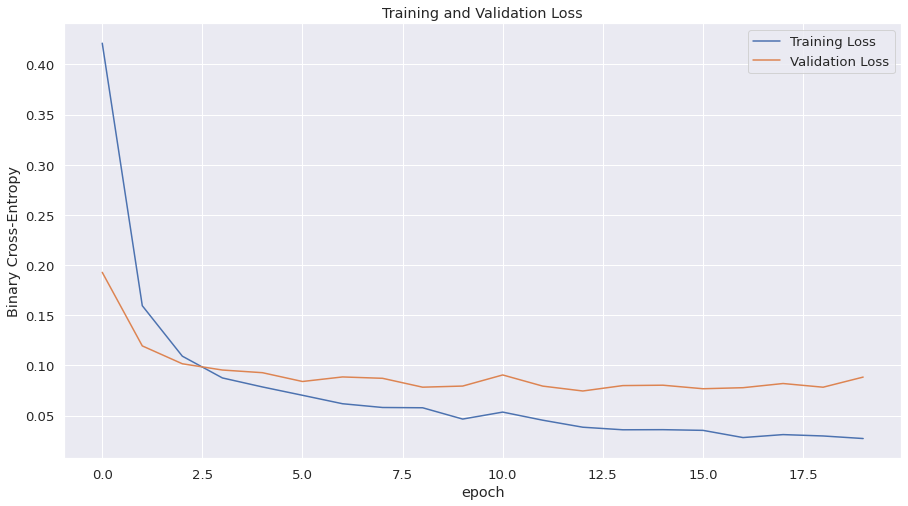

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross-Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning of the base_model

In [72]:
#Unfreezing the last 11 layers of the base_model which correspond to the last convolutional block 
base_model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-11]:
  layer.trainable = False  

In [73]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 887,361
Non-trainable params: 1,371,904
_________________________________________________________________


In [74]:
from keras.optimizers import Adam
#Compiling the model for the fine-tuning phase, using the same parameters as the first training but decreasing the learning rate of the optimizer
model.compile(
      optimizer = Adam(learning_rate=1e-8), 
      loss='binary_crossentropy', 
      metrics=['Precision','Recall','accuracy']
      )

In [76]:
#Fine tuning
fthistory = model.fit(train_images, 
                    epochs=20+10,
                    initial_epoch=20,
                    validation_data=val_images,
                    callbacks = callbacks
                    )

Epoch 21/30
23/23 [==============================] - ETA: 0s - loss: 0.0219 - precision: 0.9945 - recall: 0.9890 - accuracy: 0.9959
Epoch 21: val_loss did not improve from 0.07188
23/23 [==============================] - 39s 2s/step - loss: 0.0219 - precision: 0.9945 - recall: 0.9890 - accuracy: 0.9959 - val_loss: 0.0863 - val_precision: 0.9545 - val_recall: 0.9333 - val_accuracy: 0.9727
Epoch 22/30
23/23 [==============================] - ETA: 0s - loss: 0.0208 - precision: 0.9836 - recall: 0.9890 - accuracy: 0.9932
Epoch 22: val_loss did not improve from 0.07188
23/23 [==============================] - 76s 3s/step - loss: 0.0208 - precision: 0.9836 - recall: 0.9890 - accuracy: 0.9932 - val_loss: 0.0868 - val_precision: 0.9762 - val_recall: 0.9111 - val_accuracy: 0.9727
Epoch 23/30
23/23 [==============================] - ETA: 0s - loss: 0.0212 - precision: 0.9890 - recall: 0.9890 - accuracy: 0.9946
Epoch 23: val_loss did not improve from 0.07188
23/23 [==============================]

In [77]:
np.save('fthistory.npy',fthistory.history)

In [80]:
#Adding the fine-tuning phase values to the initial training
fthistory=np.load('drive/MyDrive/DS/fthistory.npy',allow_pickle='TRUE').item()
acc += fthistory['accuracy']
val_acc += fthistory['val_accuracy']

loss += fthistory['loss']
val_loss += fthistory['val_loss']

precision += fthistory['precision']
val_precision += fthistory['val_precision']

recall += fthistory['recall']
val_recall += fthistory['val_recall']

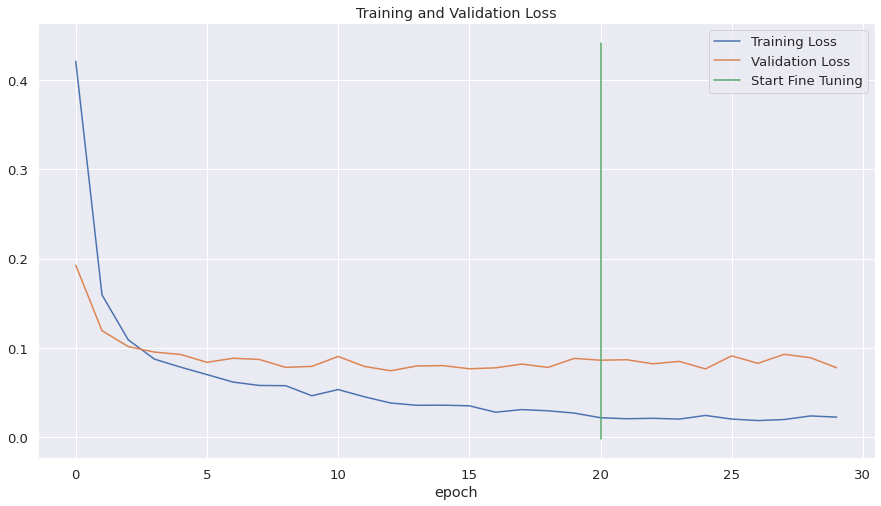

In [81]:
plt.figure(figsize=(15, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([20,20],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# METRICS EVALUATION

### KFold Cross Validation

In [38]:
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model
#Instantiatin a Stratifield KFold cross validation class on 5 splits
skf = StratifiedKFold(n_splits=5)
#Divinding the main dataframe into two colums: one with filepaths and one with labels
X=image_df.drop('Label', axis=1)
y=image_df.Label
fold_num=0
results = []

#For loop for iterating over each fold combination
for train_index, val_index in skf.split(X, y):
    fold_num += 1
    #Creating training and test labels and filepaths using the indexes provided from the split method of the StratifiedKFold class
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    
    #Concatenate labels and filepaths to create dataframes for training and validation
    Ktrain = pd.concat([X_train,y_train], axis=1)
    Kval = pd.concat([X_test,y_test], axis=1)
    
    #Printing the Frequency count of each class in the training and validation dataframes to check if it is equal to the original one
    print("\n***Frequency of classes in the fold***\n")
    print(Ktrain['Label'].value_counts(normalize=True))
    print(Kval['Label'].value_counts(normalize=True))
    print("\n")

    #Using the ImageDataGenerator as above to create DataFrameIterators from dataframes
    datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                               rotation_range=10,
                               horizontal_flip='True')
    
    train_images = datagen.flow_from_dataframe(dataframe=Ktrain,
                                               x_col='Filepath',
                                               y_col='Label',
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               class_mode='binary',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=42
                                               )
    
    val_images = datagen.flow_from_dataframe(dataframe=Kval,
                                             x_col='Filepath',
                                             y_col='Label',
                                             target_size=(224, 224),
                                             color_mode='rgb',
                                             class_mode='binary',
                                             batch_size=32,
                                             shuffle=True,
                                             seed=42
                                             )
    
    print("\nTrain for fold", fold_num)
    #Building the model and callbacks for each model 
    kmodel=build_model()
    base_model.trainable = False
    name = datetime.now().strftime("kfold_%d_%m_%Y_%H_%M_%S.keras")  
    
    kcallbacks = [keras.callbacks.ModelCheckpoint(filepath=name,
                                                  verbose=1,
                                                  save_best_only=True,
                                                  monitor="val_loss")
    ]
    kmodel.compile(optimizer = "Adam",
                   loss='binary_crossentropy',
                   metrics=['Precision','Recall','accuracy']
                   )

    #Training the model on 4 folds and validating on the remaining one
    khistory = kmodel.fit(train_images,
                          epochs=10,
                          validation_data=val_images,
                          callbacks = kcallbacks
                          )
    
    #Evaluating the performance of the model on the validation data
    print("***Performance on Validation data***")
    kmodel=load_model(name)
    #Saving the performances of the model into the results variable
    results.append(kmodel.evaluate(val_images))


***Frequency of classes in the fold***

fire_images        0.752381
non_fire_images    0.247619
Name: Label, dtype: float64
fire_images        0.755435
non_fire_images    0.244565
Name: Label, dtype: float64


Found 735 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.

Train for fold 1
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 0.3826 - precision: 0.9294 - recall: 0.4341 - accuracy: 0.8517
Epoch 1: val_loss improved from inf to 0.15435, saving model to kfold_15_03_2023_09_10_36.keras
23/23 [==============================] - 47s 2s/step - loss: 0.3826 - precision: 0.9294 - recall: 0.4341 - accuracy: 0.8517 - val_loss: 0.1543 - val_precision: 0.9302 - val_recall: 0.8889 - val_accuracy: 0.9565
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.1234 - precision: 0.9758 - recall: 0.8846 - accuracy: 0.9660
Epoch 2: val_loss improved from 0.15435 to 0.07933, saving model to kfold_15_03_20

In [39]:
np.save("kfoldres",results)

In [41]:
results = np.load('drive/MyDrive/DS/kfoldres.npy',allow_pickle='TRUE')

In [42]:
#Calculating the mean metrics by summing all the values and then diving by 5
metrics = np.sum(results, axis=0)/5

In [43]:
print("Mean Loss among 5 folds = ", metrics[0])
print("Mean Precision among 5 folds = ", metrics[1])
print("Mean Recall among 5 folds = ", metrics[2])
print("Mean Accuracy among 5 folds = ", metrics[3])

Mean Loss among 5 folds =  0.06430950239300728
Mean Precision among 5 folds =  0.9775757551193237
Mean Recall among 5 folds =  0.9383574962615967
Mean Accuracy among 5 folds =  0.979318130016327


### Fine tuned model metrics

In [87]:
from keras.models import load_model
model = load_model("drive/MyDrive/DS/fire_15_03_2023_10_04_22.keras")

In [88]:
model.evaluate(test_images)
#Prediction of the model on the test set
preds= model.predict(test_images)
#iterating all the predictions to round probability and have the number of the class in y_preds
y_preds = [int(round(p[0])) for p in preds]

3/3 [==============================] - 4s 834ms/step


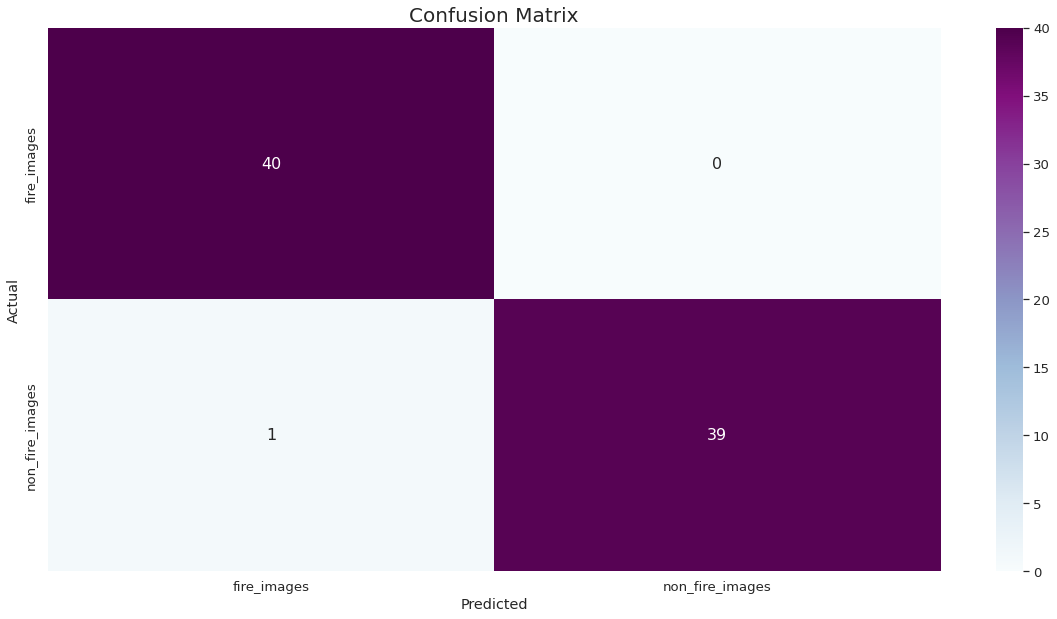

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

#Plotting the confusion matrix using test_images.class as the actual labels and y_preds as Predicted ones
classes=image_df['Label'].unique()

cm_data = confusion_matrix(test_images.classes , y_preds)
cm = pd.DataFrame(cm_data, columns=classes, index = classes) 
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=True, cmap="BuPu", annot=True, annot_kws={"size": 16}, fmt='g')

In [90]:
from sklearn.metrics import classification_report
#Classification report of the model
print(classification_report(test_images.classes, y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

